In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,15
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,accuracy_score ,confusion_matrix
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import RobustScaler

import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm ,tnrange

In [2]:
train_data = pd.read_csv('train.csv')

print(train_data.shape)

train_data.head()

(304887, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,350957,Male,50,1,41,0,1-2 Year,Yes,35915,124,240,0
1,239788,Female,48,1,28,0,1-2 Year,Yes,26873,124,274,0
2,348272,Female,34,1,41,0,1-2 Year,Yes,2630,156,138,1
3,73940,Female,43,1,28,0,1-2 Year,Yes,46877,124,223,0
4,292871,Male,29,1,28,1,< 1 Year,No,38009,152,106,0


In [3]:
test_data = pd.read_csv('test.csv')

print(test_data.shape)

test_data.head()

(76222, 11)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,291378,Male,31,1,18,0,1-2 Year,Yes,2630,156,152
1,154746,Female,24,1,15,1,< 1 Year,No,28105,152,267
2,218512,Female,25,1,14,1,< 1 Year,No,29302,152,139
3,173930,Male,49,1,28,0,1-2 Year,Yes,28357,26,12
4,241471,Male,55,1,45,0,1-2 Year,Yes,33288,26,44


In [4]:
x = train_data[~train_data.iloc[:,1:].duplicated(keep = 'first')]

#reemove confusing ids

train_data = train_data[~train_data.id.isin(x[x.iloc[:,1:-1].duplicated(keep = False)].id)]

In [5]:
def nullColumns(train_data):
    
    list_of_nullcolumns =[]
    
    for column in train_data.columns:
        
        total= train_data[column].isna().sum()
        
        try:
            
            if total !=0:
                
                print('Total Na values is {0} for column {1}' .format(total, column))
                
                list_of_nullcolumns.append(column)
        
        except:
            
            print(column,"-----",total)
    
    print('\n')
    
    return list_of_nullcolumns
def percentMissingFeature(data):
    
    data_na = (data.isnull().sum() / len(data)) * 100
    
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
    
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    
    return data_na
def plotMissingFeature(data_na):
    
    f, ax = plt.subplots(figsize=(15, 12))
    
    plt.xticks(rotation='90')
    
    if(data_na.empty ==False):
        
        sns.barplot(x=data_na.index, y=data_na)
        
        plt.xlabel('Features', fontsize=15)
        
        plt.ylabel('Percent of missing values', fontsize=15)
        
        plt.title('Percent missing data by feature', fontsize=15)

In [6]:
print('train data')

print(nullColumns(train_data))

print(percentMissingFeature(train_data))

print('\n')

print('test_data')

print(nullColumns(test_data))

print(percentMissingFeature(test_data))

train data


[]
Series([], dtype: float64)


test_data


[]
Series([], dtype: float64)


In [7]:
train_data.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,304821.000000,304821.000000,304821.000000,304821.000000,304821.000000,304821.000000,304821.000000,304821.000000,304821.000000
mean,190463.855748,38.831721,0.997874,26.380564,0.458535,30573.970452,112.026740,154.296121,0.122275
std,109997.900939,15.521569,0.046058,13.235079,0.498278,17252.514962,54.210806,83.711808,0.327604
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95184.000000,25.000000,1.000000,15.000000,0.000000,24416.000000,29.000000,82.000000,0.000000
50%,190491.000000,36.000000,1.000000,28.000000,0.000000,31676.000000,133.000000,154.000000,0.000000
75%,285639.000000,49.000000,1.000000,35.000000,1.000000,39396.000000,152.000000,227.000000,0.000000
max,381108.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


Text(0.5, 1.0, 'Response')

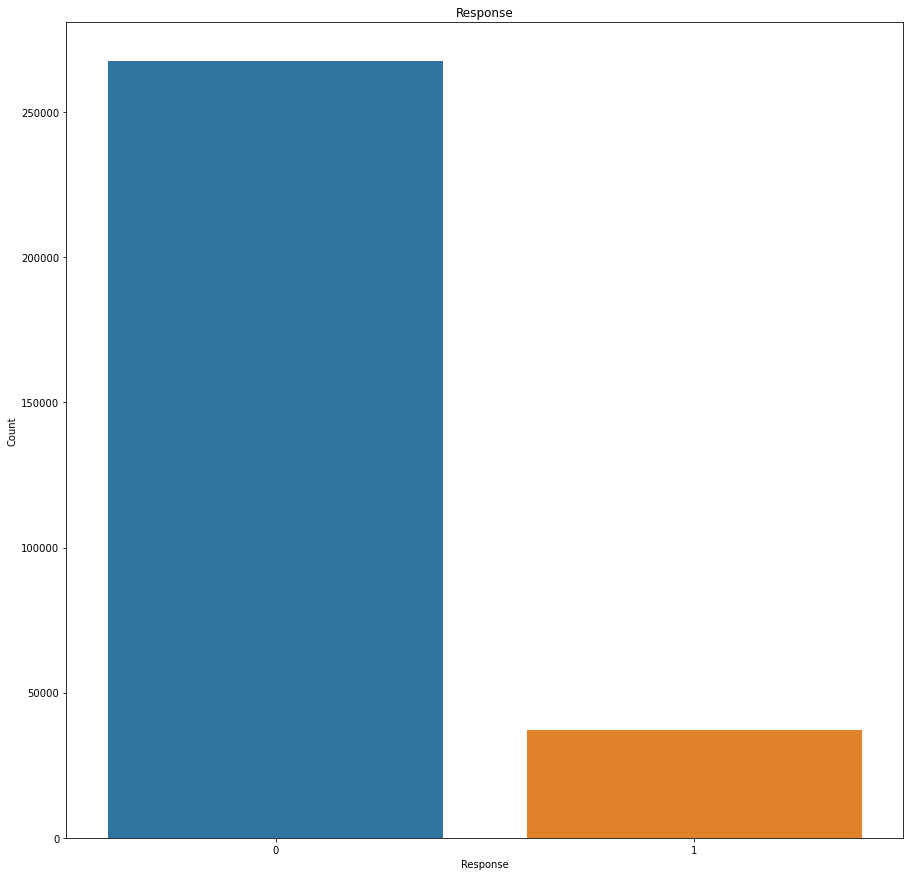

In [8]:
response = train_data.loc[:,"Response"].value_counts().rename('Count')
plt.xlabel("Response")
plt.ylabel('Count')
sns.barplot(response.index , response.values).set_title('Response')

In [9]:
response

0    267549
1     37272
Name: Count, dtype: int64

<AxesSubplot:xlabel='Vintage', ylabel='Density'>

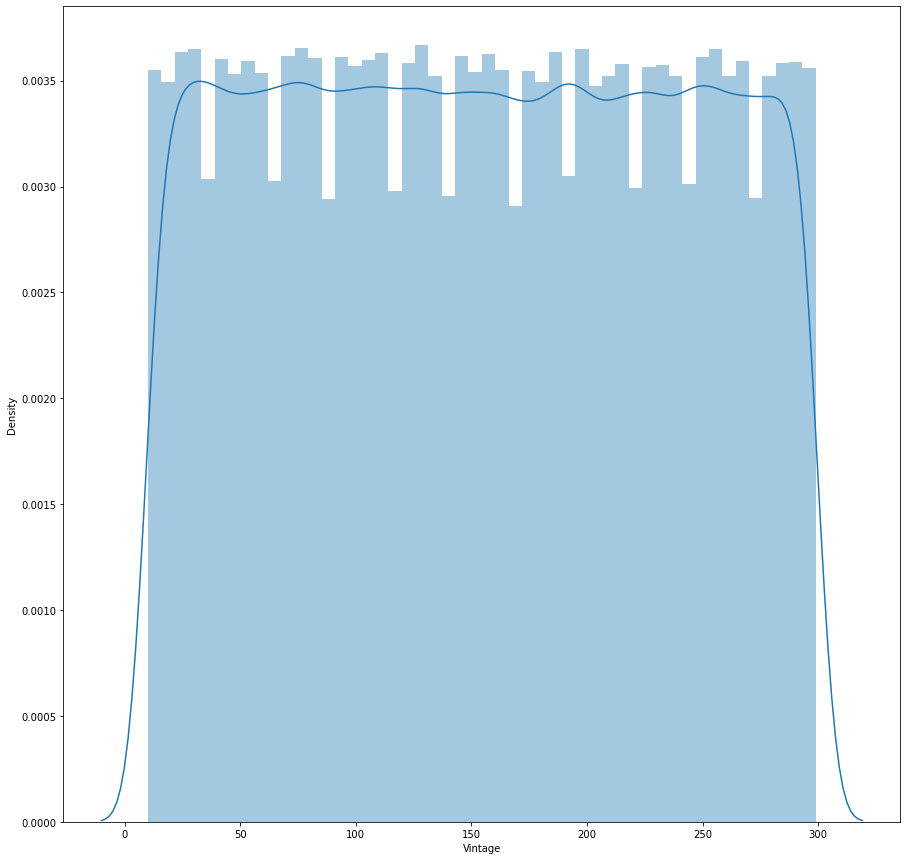

In [10]:
sns.distplot(train_data['Vintage'])

<AxesSubplot:xlabel='Annual_Premium', ylabel='Density'>

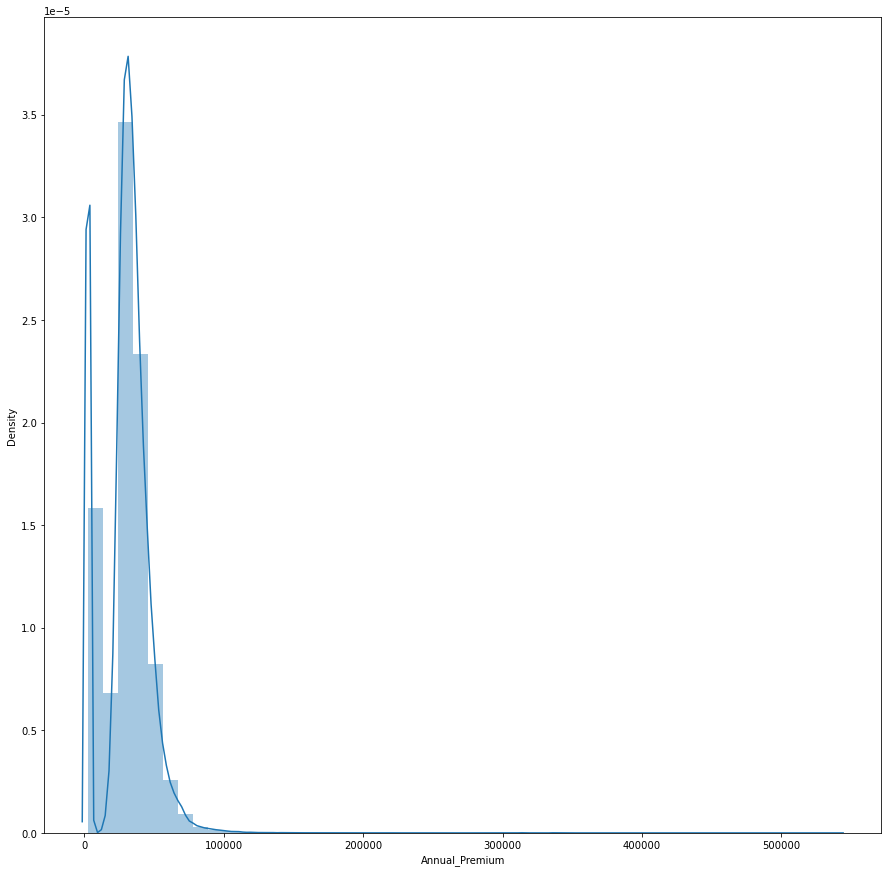

In [11]:
sns.distplot(train_data['Annual_Premium'])

<AxesSubplot:xlabel='Annual_Premium', ylabel='Density'>

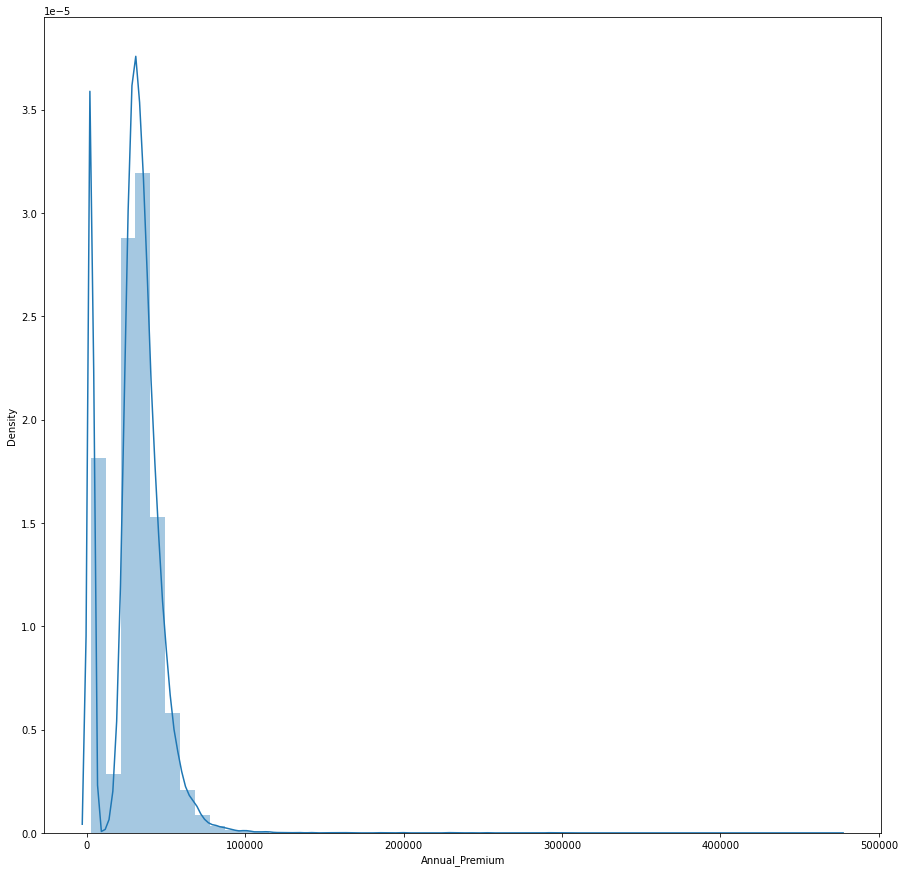

In [12]:
sns.distplot(test_data['Annual_Premium'])

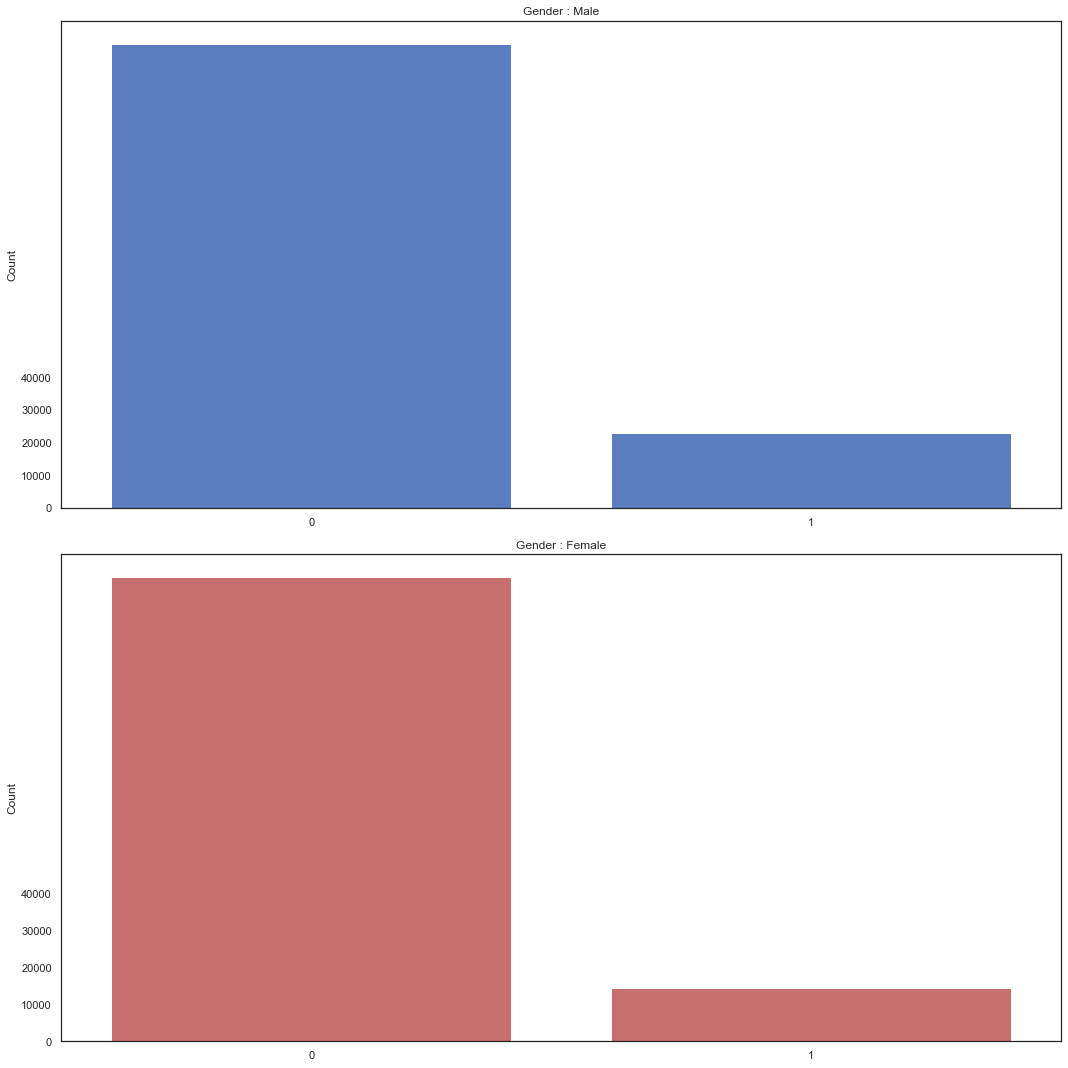

In [13]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(2, 1, figsize=(15, 15))

male = train_data[train_data['Gender'] =='Male']["Response"].value_counts().rename('Count')

female = train_data[train_data['Gender'] =='Female']["Response"].value_counts().rename('Count')

sns.barplot(male.index,male,  color="b", ax=axes[0]).set_title('Gender : Male')

sns.barplot(female.index,female,   color="r", ax=axes[1]).set_title('Gender : Female')

plt.setp(axes, yticks = np.arange(0,50000,10000))

for ax in f.axes:
    
    plt.sca(ax)
    
    plt.xticks(rotation=0)

plt.tight_layout()

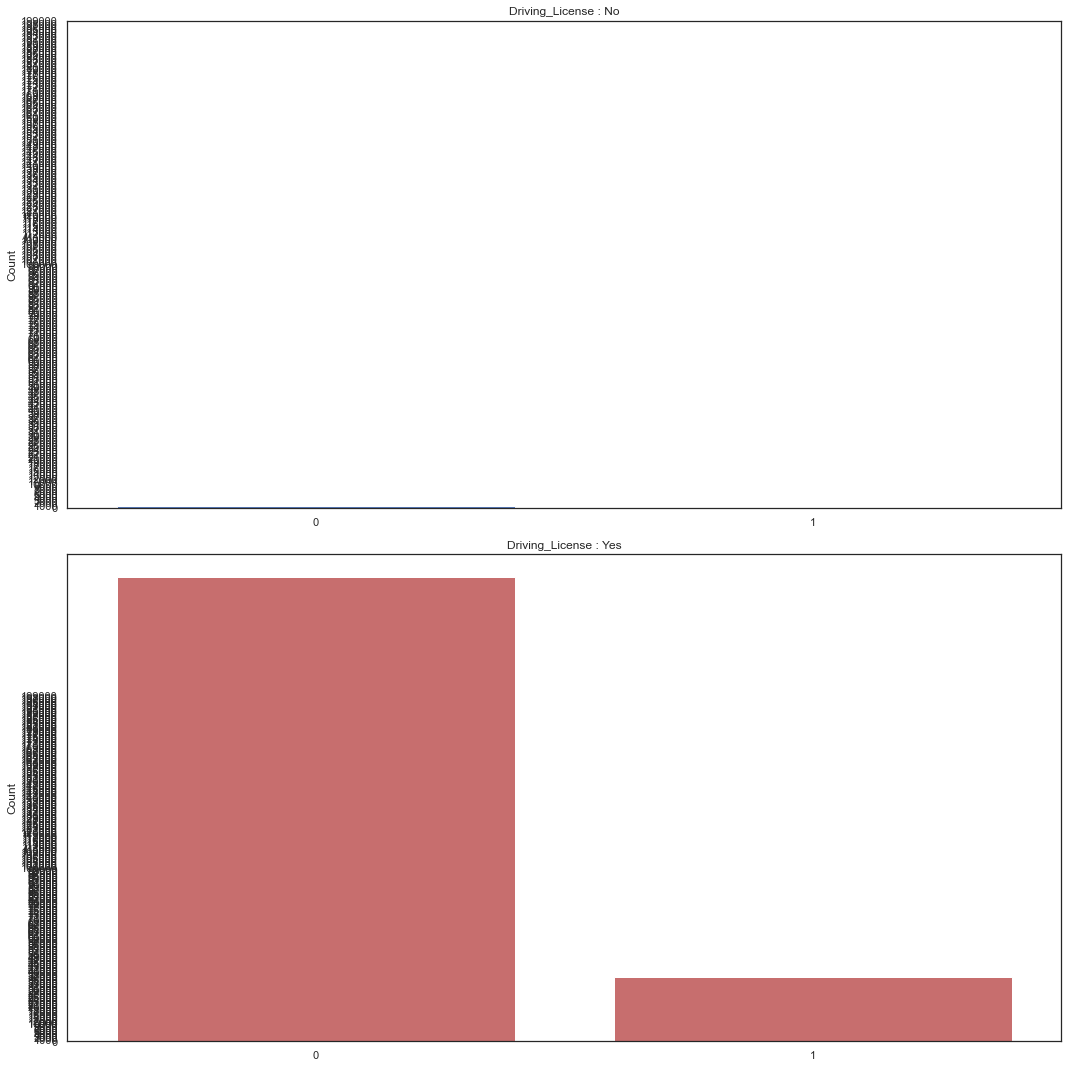

In [14]:

sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(2, 1, figsize=(15, 15))

dl0 = train_data[train_data['Driving_License'] ==0]["Response"].value_counts().rename('Count')

dl1 = train_data[train_data['Driving_License'] ==1]["Response"].value_counts().rename('Count')

sns.barplot(dl0.index,dl0,  color="b", ax=axes[0]).set_title('Driving_License : No')

sns.barplot(dl1.index,dl1,   color="r", ax=axes[1]).set_title('Driving_License : Yes')

plt.setp(axes, yticks = np.arange(0,200000,1000))

for ax in f.axes:
    
    plt.sca(ax)
    
    plt.xticks(rotation=0)

plt.tight_layout()

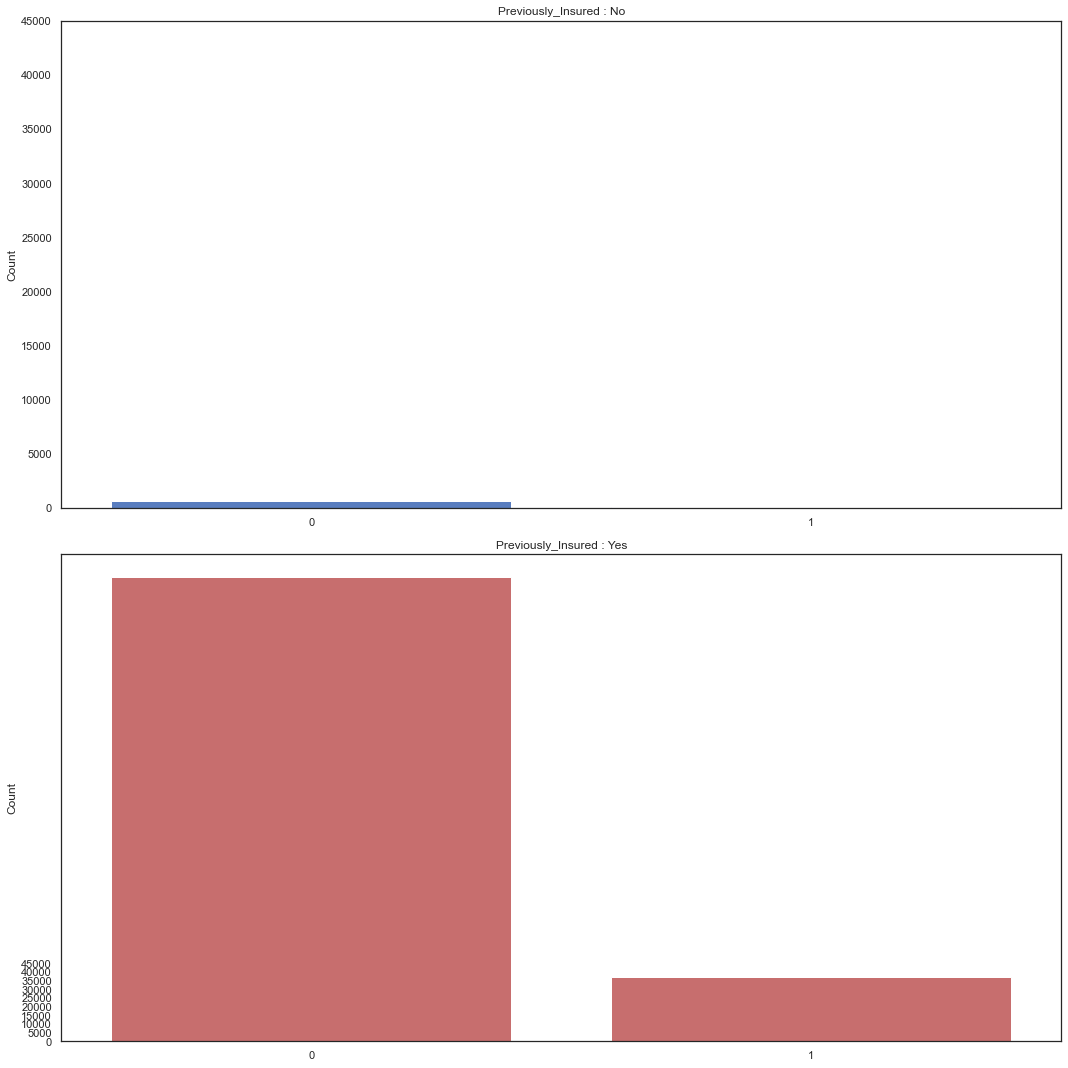

In [15]:
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(2, 1, figsize=(15, 15))

pi0 = train_data[train_data['Previously_Insured'] ==0]["Response"].value_counts().rename('Count')

pi1 = train_data[train_data['Previously_Insured'] ==1]["Response"].value_counts().rename('Count')

sns.barplot(dl0.index,dl0,  color="b", ax=axes[0]).set_title('Previously_Insured : No')

sns.barplot(dl1.index,dl1,   color="r", ax=axes[1]).set_title('Previously_Insured : Yes')

plt.setp(axes, yticks = np.arange(0,50000,5000))

for ax in f.axes:
    
    plt.sca(ax)
    
    plt.xticks(rotation=0)

plt.tight_layout()

In [8]:
train_data['Policy_Region'] = train_data['Policy_Sales_Channel'].astype(str)+'_'+train_data['Region_Code'].astype(str)

test_data['Policy_Region'] = test_data['Policy_Sales_Channel'].astype(str)+'_'+test_data['Region_Code'].astype(str)

train_data['Vehicle_Age_License'] = train_data['Vehicle_Age'].astype(str)+'_'+train_data['Driving_License'].astype(str)

test_data['Vehicle_Age_License'] = test_data['Vehicle_Age'].astype(str)+'_'+test_data['Driving_License'].astype(str)

In [9]:
train_data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Policy_Region,Vehicle_Age_License
0,350957,Male,50,1,41,0,1-2 Year,Yes,35915,124,240,0,124_41,1-2 Year_1
1,239788,Female,48,1,28,0,1-2 Year,Yes,26873,124,274,0,124_28,1-2 Year_1
2,348272,Female,34,1,41,0,1-2 Year,Yes,2630,156,138,1,156_41,1-2 Year_1
3,73940,Female,43,1,28,0,1-2 Year,Yes,46877,124,223,0,124_28,1-2 Year_1
4,292871,Male,29,1,28,1,< 1 Year,No,38009,152,106,0,152_28,< 1 Year_1


In [17]:
cat_features = ['Gender','Driving_License','Region_Code','Previously_Insured',
                'Vehicle_Damage','Policy_Sales_Channel','Policy_Region',
                'Vehicle_Age','Vintage','Annual_Premium','Vehicle_Age_License']

cont_features = ['Age']

label = 'Response'

In [18]:
def encode_cat_cols(train, test, cat_cols): #target

    train_df = train_data.copy()
    
    test_df = test_data.copy()
    
    # Making a dictionary to store all the labelencoders for categroical columns to transform them later.
    
    le_dict = {}

    for col in cat_cols:
        
        if col!= 'Vehicle_Age':
        
            le = LabelEncoder()

            le.fit(train_df[col].unique().tolist() + test_df[col].unique().tolist())

            train_df[col] = le.transform(train_df[[col]])

            test_df[col] = le.transform(test_df[[col]])

            le_dict[col] = le
        
    train_df['Vehicle_Age'] = train_df['Vehicle_Age'].map({'< 1 Year':1,'1-2 Year':2,'> 2 Years':3})
    
    test_df['Vehicle_Age'] = test_df['Vehicle_Age'].map({'< 1 Year':1,'1-2 Year':2,'> 2 Years':3})
    le = LabelEncoder()
    
    train_df[label] = le.fit_transform(train_df[[label]])
    
    le_dict[label] = le
    
    
    return train_df, test_df, le_dict

In [19]:
train_df, test_df, le_dict = encode_cat_cols(train_data,test_data,cat_features)

In [20]:
train_df = train_df[~train_df.Policy_Sales_Channel.isin(list(set(train_df.Policy_Sales_Channel)-set(test_df.Policy_Sales_Channel)))]

In [21]:
test_df.loc[(test_df.Policy_Sales_Channel==137),'Policy_Sales_Channel'] = -1

test_df.loc[(test_df.Policy_Sales_Channel==136),'Policy_Sales_Channel'] = -1

In [22]:
train_df['train'] = 1

test_df['train'] = 0

combined_data = pd.concat([train_df,test_df],axis =0).reset_index(drop = True).copy()

In [23]:
premium_discretizer = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')

combined_data['Premium_Bins'] =premium_discretizer.fit_transform(combined_data['Annual_Premium'].values.reshape(-1,1)).astype(int)

age_discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')

combined_data['Age_Bins'] =age_discretizer.fit_transform(combined_data['Age'].values.reshape(-1,1)).astype(int)

<AxesSubplot:xlabel='Response', ylabel='Age'>

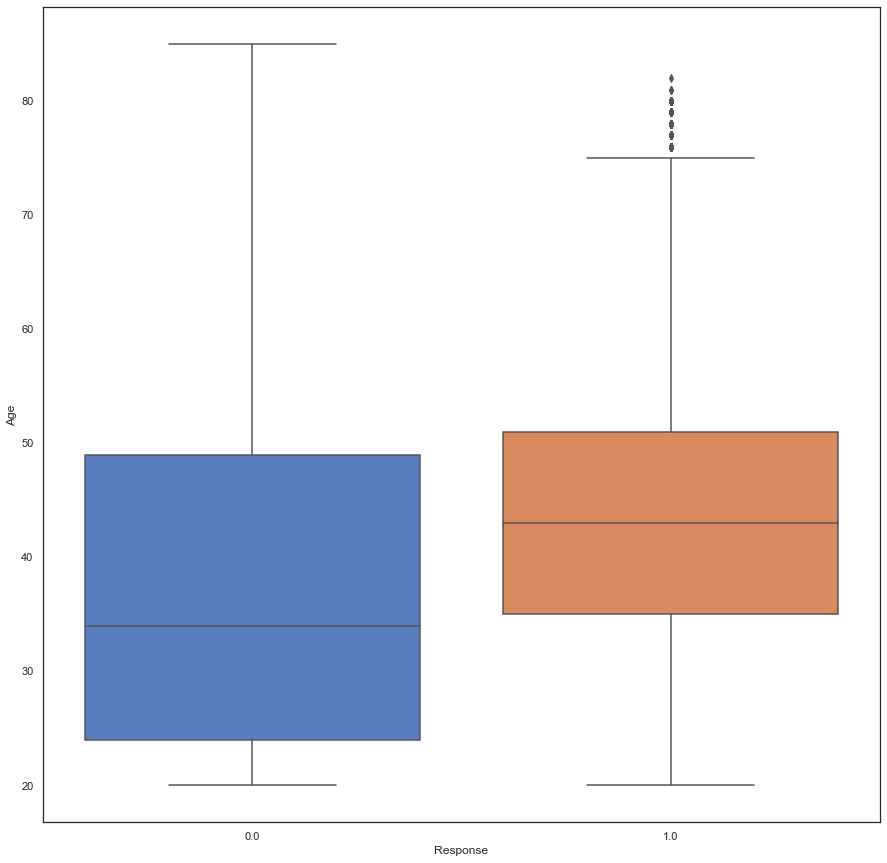

In [24]:
sns.boxplot(combined_data[combined_data['train']==1]['Response'],combined_data[combined_data['train']==1]['Age'])

<AxesSubplot:xlabel='Response', ylabel='Age_Bins'>

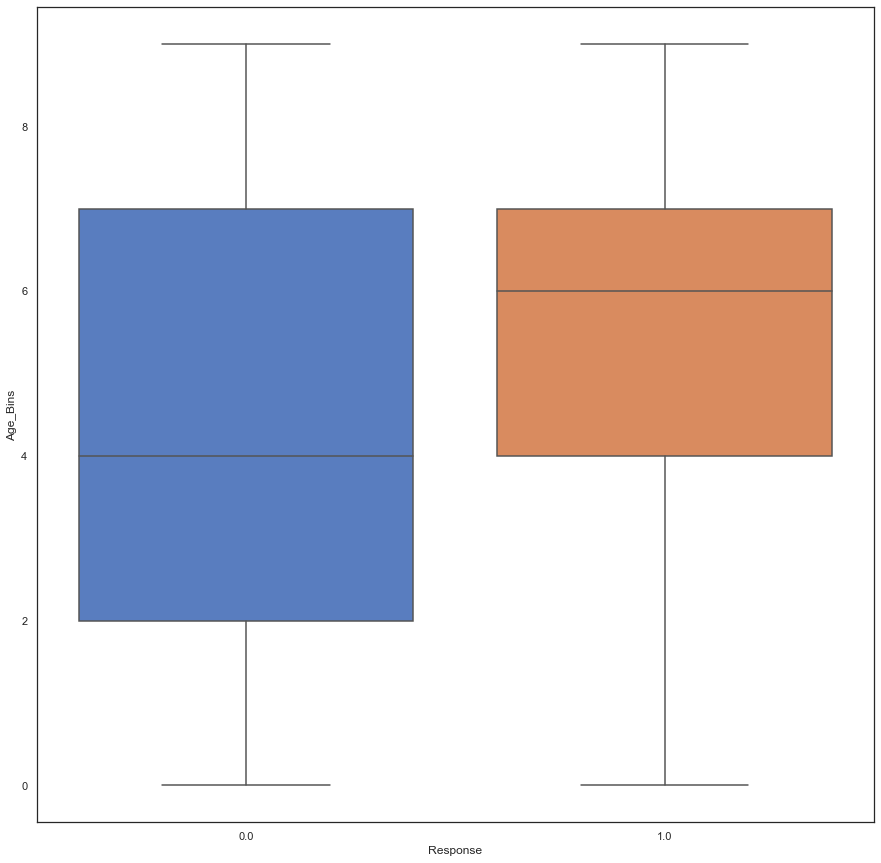

In [25]:
sns.boxplot(combined_data[combined_data['train']==1]['Response'],combined_data[combined_data['train']==1]['Age_Bins'])

In [26]:
gender_counts = combined_data['Gender'].value_counts().to_dict()

combined_data['Gender_Counts'] = combined_data['Gender'].map(gender_counts)

region_counts = combined_data['Region_Code'].value_counts().to_dict()

combined_data['Region_counts'] = combined_data['Region_Code'].map(region_counts)

vehicle_age_counts = combined_data['Vehicle_Age'].value_counts().to_dict()

combined_data['Vehicle_Age_Counts'] = combined_data['Vehicle_Age'].map(vehicle_age_counts)

In [27]:
combined_data['Nunq_Policy_Per_Region'] = combined_data.groupby('Region_Code')['Policy_Sales_Channel'].transform('nunique') 

combined_data['SDev_Annual_Premium_Per_Region_Code_int'] = combined_data.groupby('Region_Code')['Annual_Premium'].transform('std').fillna(-1) 

combined_data['Nunq_Region_Per_Premium'] = combined_data.groupby('Annual_Premium')['Region_Code'].transform('nunique')
combined_data['SDev_Annual_Premium_Per_Region_Code_dec'] = combined_data['SDev_Annual_Premium_Per_Region_Code_int'] %1

combined_data['SDev_Annual_Premium_Per_Region_Code_int'] =combined_data['SDev_Annual_Premium_Per_Region_Code_int'].astype(int)


combined_data['Avg_Policy_Region_Age'] = combined_data.groupby(['Policy_Region'])['Age'].transform('mean')

combined_data['Avg_Policy_Region_Premium'] = combined_data.groupby(['Policy_Region'])['Annual_Premium'].transform('mean') 

combined_data['Avg_Region_Premium'] = combined_data.groupby(['Region_Code'])['Annual_Premium'].transform('mean')

combined_data['Nunq_Premium_Region'] = combined_data.groupby(['Annual_Premium'])['Region_Code'].transform('nunique')

In [28]:
train_df = combined_data[combined_data['train']==1]

test_df = combined_data[combined_data['train']==0]

In [29]:
cols = ['Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage',
        'Annual_Premium','Policy_Sales_Channel', 'Vintage']

train_df = train_df[~train_df.loc[:,cols].duplicated(keep = 'first')].reset_index(drop=True)

In [30]:
target = train_df['Response']

train_df = train_df.drop(columns =['train','id','Response'])

test_df = test_df.drop(columns=['train','id','Response'])

In [31]:
test_size = 0.34

train_df

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,...,Region_counts,Vehicle_Age_Counts,Nunq_Policy_Per_Region,SDev_Annual_Premium_Per_Region_Code_int,Nunq_Region_Per_Premium,SDev_Annual_Premium_Per_Region_Code_dec,Avg_Policy_Region_Age,Avg_Policy_Region_Premium,Avg_Region_Premium,Nunq_Premium_Region
0,1,50,1,41,0,2,1,19054,119,230,...,18259,200206,62,10314,8,0.145360,45.801068,16202.092457,15429.836738,8
1,0,48,1,28,0,2,1,10012,119,264,...,106369,200206,114,12045,12,0.339735,46.977162,21794.975819,21995.699527,12
2,0,34,1,41,0,2,1,0,149,128,...,18259,200206,62,10314,53,0.145360,37.940217,4440.746377,15429.836738,53
3,0,43,1,28,0,2,1,29971,119,213,...,106369,200206,114,12045,2,0.339735,46.977162,21794.975819,21995.699527,2
4,1,29,1,28,1,1,0,21148,145,96,...,106369,164773,114,12045,3,0.339735,27.114327,23320.554648,21995.699527,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304574,1,69,1,44,0,3,1,11460,24,260,...,808,16003,24,8686,12,0.579260,49.112903,9993.290323,11052.141089,12
304575,1,24,1,50,1,1,0,17594,145,58,...,10236,164773,54,9362,7,0.889853,26.391275,16420.179050,15670.652696,7
304576,0,46,1,28,0,2,1,48641,147,145,...,106369,200206,114,12045,1,0.339735,40.585625,19139.308750,21995.699527,1
304577,0,77,1,39,1,2,0,25078,117,50,...,4644,200206,56,10947,4,0.254409,47.173077,14988.346154,13535.427003,4


In [33]:
def feature_importance(model, X_train):

    fI = model.feature_importances_
    
    print(fI)
    
    names = X_train.columns.values
    
    ticks = [i for i in range(len(names))]
    
    plt.bar(ticks, fI)
    
    plt.xticks(ticks, names,rotation = 90)
    
    plt.show()

 
####################################################################################################
Seed 1
Fold 0
 rows of train = 201022 rows of holdout = 103557
[0]	validation_0-auc:0.83056	validation_0-logloss:0.66801
[100]	validation_0-auc:0.85660	validation_0-logloss:0.27713
[200]	validation_0-auc:0.85999	validation_0-logloss:0.26491
[300]	validation_0-auc:0.86009	validation_0-logloss:0.26339
[400]	validation_0-auc:0.85998	validation_0-logloss:0.26326
[403]	validation_0-auc:0.85998	validation_0-logloss:0.26326
XGB Val OOF AUC= 0.8600707226120707
####################################################################################################
[0.00141505 0.00860319 0.0022366  0.00191236 0.4354151  0.01691208
 0.4493837  0.00153123 0.00563451 0.00124187 0.00349397 0.00739951
 0.0009972  0.0165418  0.00161924 0.00149638 0.02260919 0.0015991
 0.00184326 0.0013051  0.00128994 0.01041466 0.00215067 0.00167684
 0.00127749]


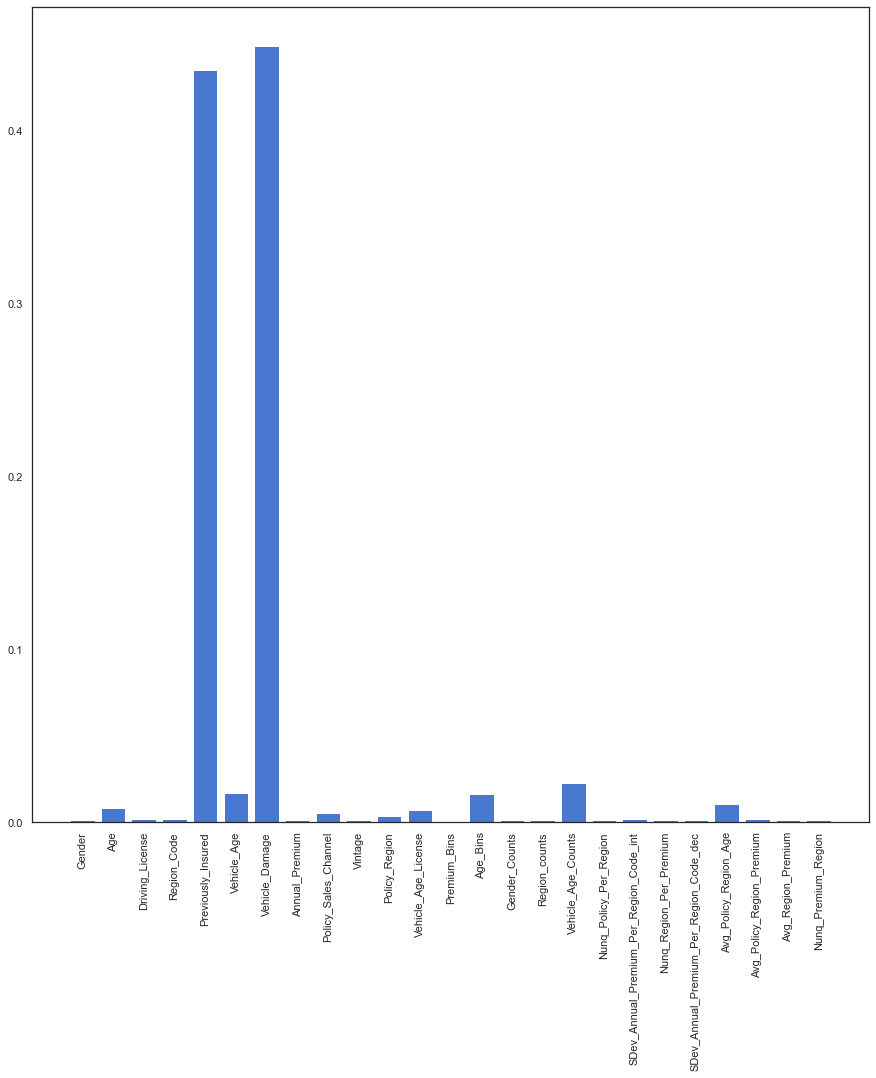

Fold 1
 rows of train = 201022 rows of holdout = 103557
[0]	validation_0-auc:0.83062	validation_0-logloss:0.66803
[100]	validation_0-auc:0.85492	validation_0-logloss:0.27770
[200]	validation_0-auc:0.85800	validation_0-logloss:0.26566
[300]	validation_0-auc:0.85809	validation_0-logloss:0.26413
[400]	validation_0-auc:0.85807	validation_0-logloss:0.26392
[419]	validation_0-auc:0.85807	validation_0-logloss:0.26393
XGB Val OOF AUC= 0.8581354976705842
####################################################################################################
Fold 2
 rows of train = 201022 rows of holdout = 103557
[0]	validation_0-auc:0.82929	validation_0-logloss:0.66802
[100]	validation_0-auc:0.85357	validation_0-logloss:0.27838
[200]	validation_0-auc:0.85709	validation_0-logloss:0.26629
[300]	validation_0-auc:0.85724	validation_0-logloss:0.26477
[400]	validation_0-auc:0.85716	validation_0-logloss:0.26453
[420]	validation_0-auc:0.85711	validation_0-logloss:0.26455
XGB Val OOF AUC= 0.8572375985646808

In [34]:
##XGBM

probs_xgb = np.zeros(shape=(len(test_df),))

scores = []

avg_loss = []

X_train_cv,y_train_cv = train_df.copy(), target.copy()

seeds = [1]

for seed in tnrange(len(seeds)):
    
    print(' ')
    
    print('#'*100)
    
    print('Seed',seeds[seed])
    
    sssf = StratifiedShuffleSplit(n_splits=5, test_size = test_size ,random_state=seed)
    
    for i, (idxT, idxV) in enumerate(sssf.split(X_train_cv, y_train_cv)):

        print('Fold',i)
        
        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        clf = xgb.XGBClassifier(n_estimators=1000,
                                max_depth=6,
                                learning_rate=0.04,
                                subsample=0.9,
                                colsample_bytree=0.35,
                                objective = 'binary:logistic',
                                random_state = 1
                               )        


        h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT], 
                    eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                    verbose=100,eval_metric=['auc','logloss'],
                    early_stopping_rounds=50)
        
        probs_oof = clf.predict_proba(X_train_cv.iloc[idxV])[:,1]
        
        probs_xgb +=clf.predict_proba(test_df)[:,1]

        roc = roc_auc_score(y_train_cv.iloc[idxV],probs_oof)

        scores.append(roc)
        
        avg_loss.append(clf.best_score)

        print ('XGB Val OOF AUC=',roc)

        print('#'*100)
        if i==0:
            
            feature_importance(clf,X_train_cv)
            
print("Log Loss Stats {0:.5f},{1:.5f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))

print('%.6f (%.6f)' % (np.array(scores).mean(), np.array(scores).std()))

 
####################################################################################################
Seed 1
Fold 0
 rows of train = 201022 rows of holdout = 103557
0:	learn: 0.6544996	test: 0.6543971	best: 0.6543971 (0)	total: 515ms	remaining: 1h 25m 46s
100:	learn: 0.2664058	test: 0.2663695	best: 0.2663695 (100)	total: 37.3s	remaining: 1h 55s
200:	learn: 0.2628967	test: 0.2638465	best: 0.2638465 (200)	total: 1m 14s	remaining: 1h 53s
300:	learn: 0.2614031	test: 0.2635035	best: 0.2635026 (297)	total: 1m 55s	remaining: 1h 1m 51s
400:	learn: 0.2601926	test: 0.2633901	best: 0.2633901 (400)	total: 2m 36s	remaining: 1h 2m 30s
500:	learn: 0.2590386	test: 0.2633366	best: 0.2633366 (500)	total: 3m 20s	remaining: 1h 3m 21s
600:	learn: 0.2580747	test: 0.2632808	best: 0.2632808 (600)	total: 4m 6s	remaining: 1h 4m 10s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2632675685
bestIteration = 626

Shrink model to first 627 iterations.
CatBoost Val OOF AUC= 0.859830198311804
[ 0

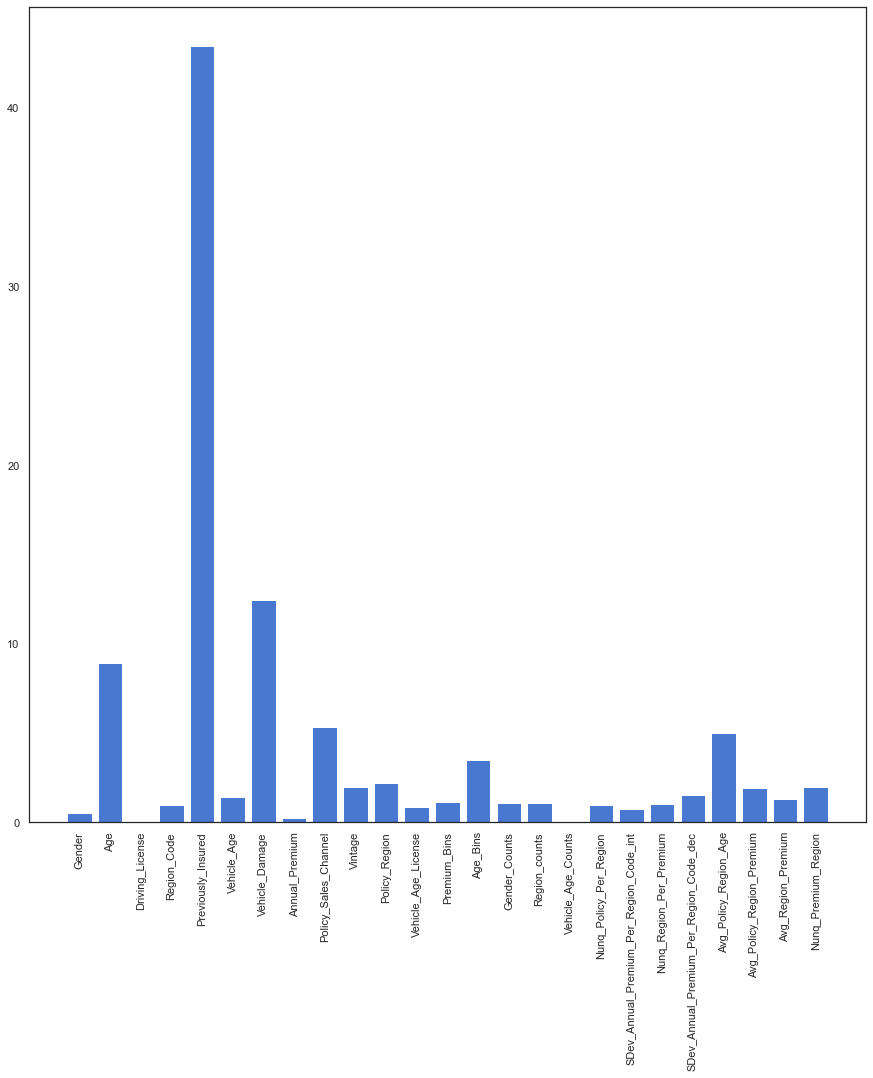

####################################################################################################
Fold 1
 rows of train = 201022 rows of holdout = 103557
0:	learn: 0.6539909	test: 0.6539388	best: 0.6539388 (0)	total: 339ms	remaining: 56m 31s
100:	learn: 0.2661742	test: 0.2665556	best: 0.2665556 (100)	total: 38.3s	remaining: 1h 2m 29s
200:	learn: 0.2627248	test: 0.2641185	best: 0.2641185 (200)	total: 1m 18s	remaining: 1h 3m 51s
300:	learn: 0.2612535	test: 0.2638008	best: 0.2638008 (300)	total: 2m 1s	remaining: 1h 5m 7s
400:	learn: 0.2600843	test: 0.2636498	best: 0.2636496 (397)	total: 2m 47s	remaining: 1h 6m 38s
500:	learn: 0.2589311	test: 0.2635989	best: 0.2635969 (492)	total: 3m 33s	remaining: 1h 7m 26s
600:	learn: 0.2578962	test: 0.2635886	best: 0.2635801 (588)	total: 4m 20s	remaining: 1h 7m 57s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2635801026
bestIteration = 588

Shrink model to first 589 iterations.
CatBoost Val OOF AUC= 0.8586325763604169
#########

In [35]:
##CatBoost

cat_features = ['Driving_License','Gender','Region_Code','Previously_Insured','Vehicle_Damage',
                'Policy_Sales_Channel','Policy_Region','Vehicle_Age','Vintage','Annual_Premium',
                'Vehicle_Age_License','Premium_Bins']

cont_features = ['Age','Age_Bins']

probs_cb = np.zeros(shape=(len(test_df),))

scores = []

avg_loss = []

X_train_cv,y_train_cv = train_df.copy(), target.copy()

seeds = [1]
for seed in tnrange(len(seeds)):
    
    print(' ')
    
    print('#'*100)
    
    print('Seed',seeds[seed])
    
    sssf = StratifiedShuffleSplit(n_splits=5, test_size = test_size ,random_state=seed)
    
    for i, (idxT, idxV) in enumerate(sssf.split(X_train_cv, y_train_cv)):

        print('Fold',i)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        clf = CatBoostClassifier(iterations=10000,
                                learning_rate=0.02,
                                random_strength=0.1,
                                depth=8,
                                loss_function='Logloss',
                                eval_metric='Logloss',
                                leaf_estimation_method='Newton',
                                random_state = 1,
                                cat_features =cat_features,
                                subsample = 0.9,
                                rsm = 0.8
                                )   
        h = clf.fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT],
                    eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                   early_stopping_rounds=50,verbose = 100)

        probs_oof = clf.predict_proba(X_train_cv.iloc[idxV])[:,1]
        
        probs_cb +=clf.predict_proba(test_df)[:,1]
        
        roc = roc_auc_score(y_train_cv.iloc[idxV],probs_oof)

        scores.append(roc)

        print ('CatBoost Val OOF AUC=',roc)

        avg_loss.append(clf.best_score_['validation']['Logloss'])

        if i==0:
            
            feature_importance(clf,X_train_cv)

        print('#'*100)

print("Log Loss Stats {0:.8f},{1:.8f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))
print('%.8f (%.8f)' % (np.array(scores).mean(), np.array(scores).std()))

In [36]:
#p1 =probs_lgb/5

p2 = probs_cb/5

p3 = probs_xgb/5

In [112]:
response=0.7*p2+0.3*p3

In [113]:
for i in range(len(response)):
    if response[i]>0.6:
        response[i]=1
    else:
        response[i]=0

In [114]:
response

array([0., 0., 0., ..., 0., 0., 0.])

In [115]:
sub=pd.DataFrame({'id':test_data['id'],
                 'Response':response})
sub.to_csv('submission.csv',index=False)

In [90]:
sub.head()

,id,Response
0,291378,0.0
1,154746,0.0
2,218512,0.0
3,173930,0.0
4,241471,0.0
